In [1]:
import os
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("..")
from src.data.mnist import MNIST
from src.model.sqvae_image import CSQVAE
from src.utils import yaml_handler

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# temperature_init = 1
# decay = 0.00001
# temperature_min = 0.0000000001

# steps = np.arange(0, 1875 * 100, 1)
# temperature_step = np.clip(
#     a=temperature_init * np.exp(-decay * steps),
#     a_max=None, a_min=temperature_min
# )
# fig, ax = plt.subplots()
# ax.plot(steps, temperature_step)
# ax.set_xlabel('step')
# ax.set_ylabel('temperature')
# ax.set_title(
#     f'Scheduled temperature decay (init={temperature_init}, decay={decay})'
# )
# plt.show()

In [3]:
v = 2
# v = 3  # semi-supervised

gpu_id = 1
device = f"cuda:{gpu_id}"
checkpoint_dir = f"../models/mnist/version_{v}"
checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]

# load config
config_path = f"{checkpoint_dir}/mnist.yaml"
config = yaml_handler.load(config_path)

# load model
model = CSQVAE(config)
model.configure_model()
model = model.to(device)
checkpoint = torch.load(checkpoint_path, weights_only=True, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [4]:
dataset_root = "../data/"
mnist = MNIST(False, root=dataset_root)
dataloader = DataLoader(
    mnist,
    1000,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [5]:
results = []
for x, labels in tqdm(iter(dataloader), total=len(dataloader), ncols=100):
    batch = (x.to(device), labels)
    results += model.predict_step(batch)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.62it/s]


In [6]:
def plot_imgs(imgs, nsamples=100, ncols=10):
    nrows = nsamples // ncols
    fig = plt.figure(figsize=(10, 10))
    axs = fig.subplots(nrows, ncols)
    axs = axs.ravel()
    for i, img in enumerate(imgs[:nsamples]):
        axs[i].imshow(img)
        axs[i].axis("off")

    plt.show()

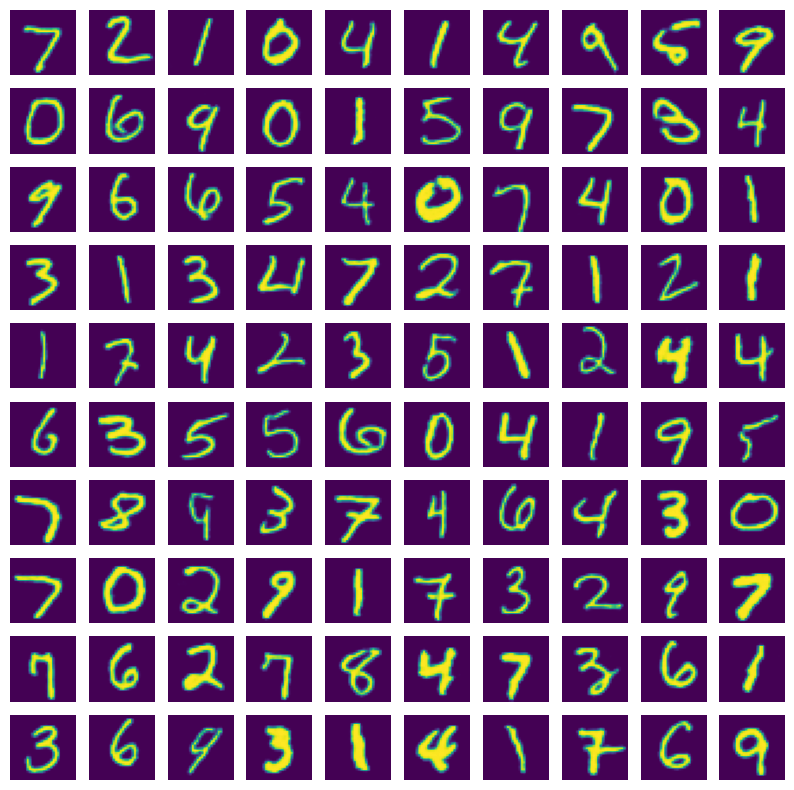

In [7]:
nsamples = 100
# imgs_true = [r["x"] for r in results[:nsamples]]
# plot_imgs(imgs_true, nsamples)
imgs_recon = [r["recon_x"] for r in results[:nsamples]]
plot_imgs(imgs_recon, nsamples)

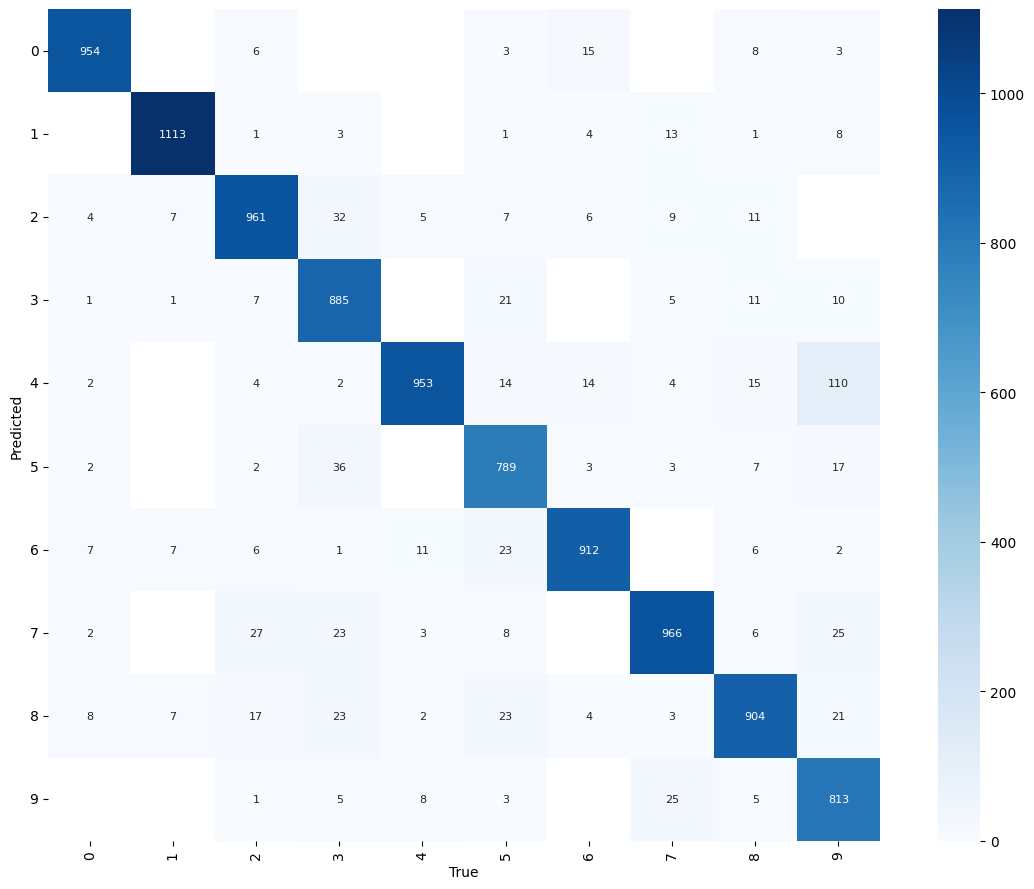

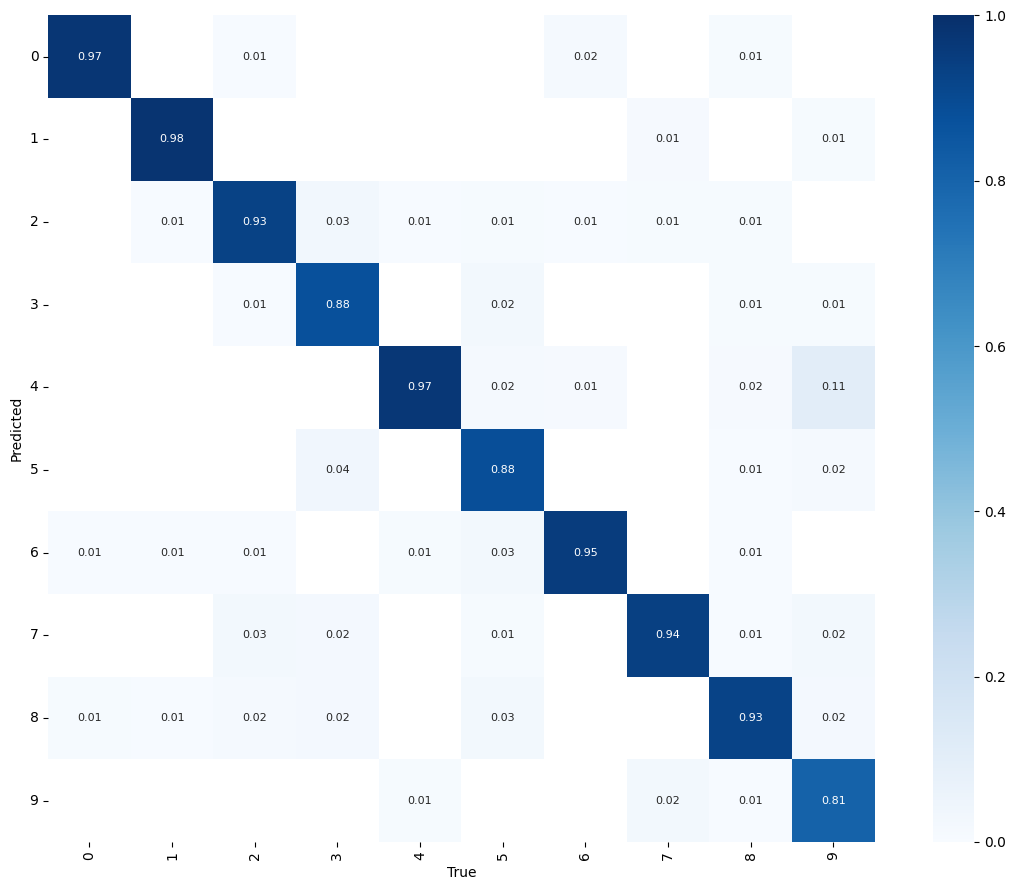

In [8]:
def plot_cm(cm, labels, save_path=None, normalize=False, on_plot=True):
    array = cm / ((cm.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
    array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    ticklabels = labels
    vmax = 1.0 if normalize else None
    sns.heatmap(
        array,
        ax=ax,
        annot=True,
        annot_kws={"size": 8},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        vmax=vmax,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

    # title = "Confusion Matrix" + " Normalized" * normalize
    # ax.set_title(title)
    ax.set_xlabel("True")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Predicted")
    ax.set_yticklabels(labels, rotation=0)
    if save_path is not None:
        if normalize:
            save_path = save_path.replace(".png", "") + "_normalized.png"
        fig.savefig(save_path, dpi=250)
    if on_plot:
        plt.show()
    plt.close(fig)


labels_pred = np.array([r["label"] for r in results])
labels_gt = np.array([r["label_gt"] for r in results])
cm = confusion_matrix(labels_gt, labels_pred).T
plot_cm(cm, np.arange(config.n_clusters), normalize=False)
plot_cm(cm, np.arange(config.n_clusters), normalize=True)

In [9]:
labels_prob = np.array([r["label_prob"] for r in results])
labels_prob[:5].astype(np.float16)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float16)

0


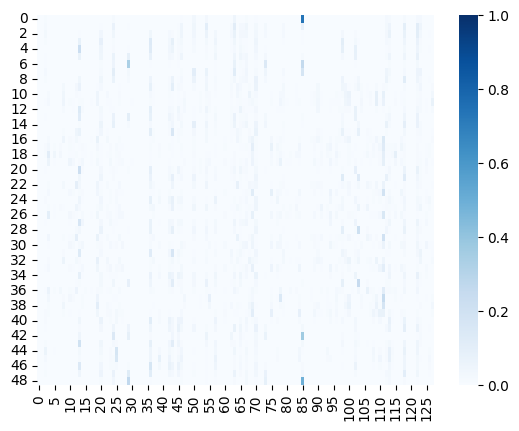

1


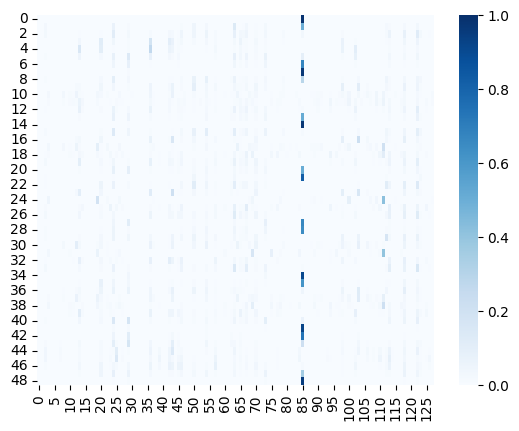

2


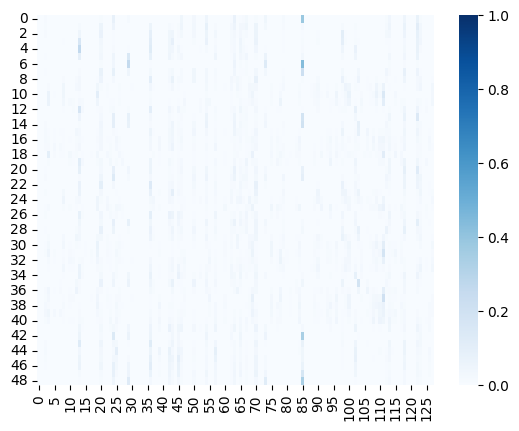

3


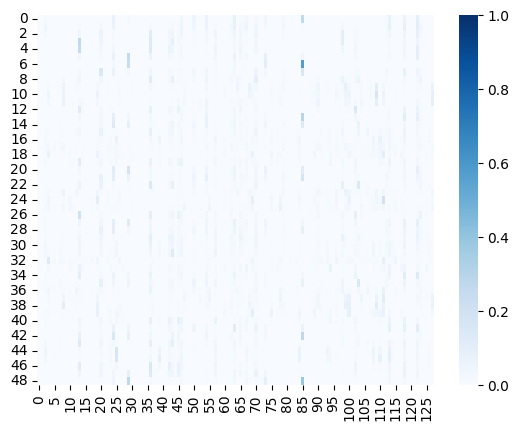

4


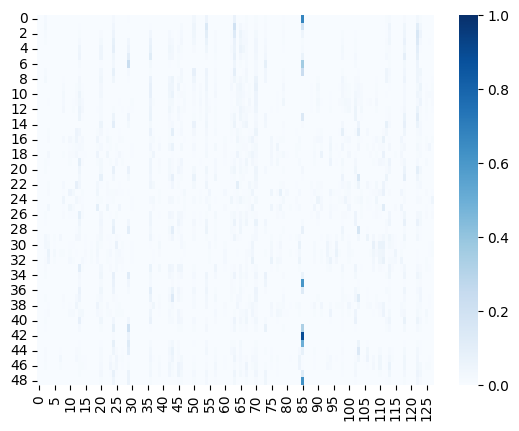

5


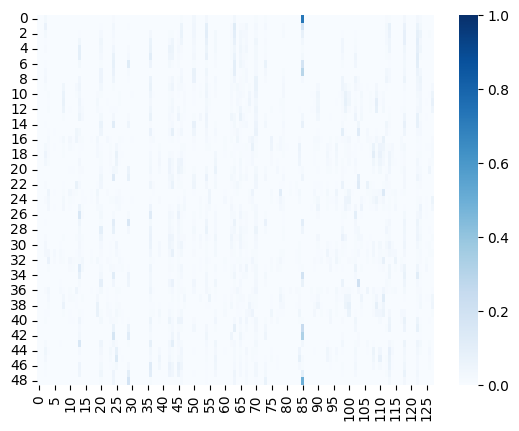

6


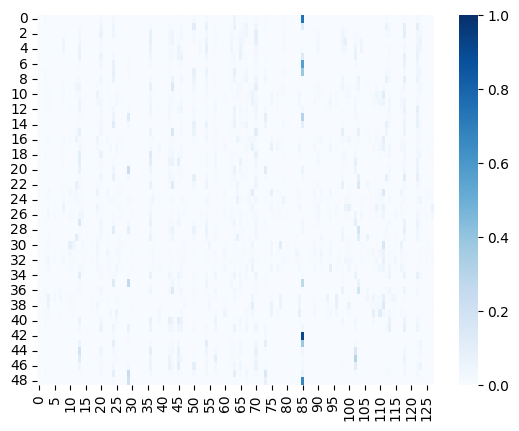

7


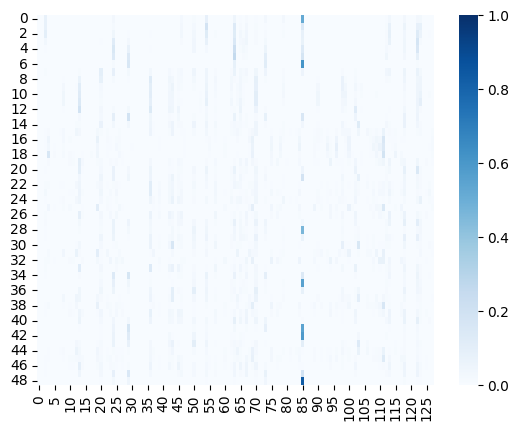

8


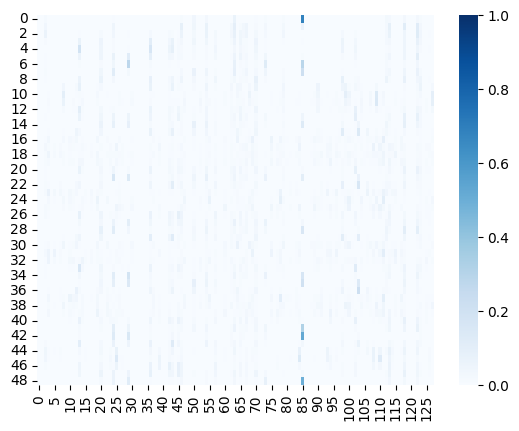

9


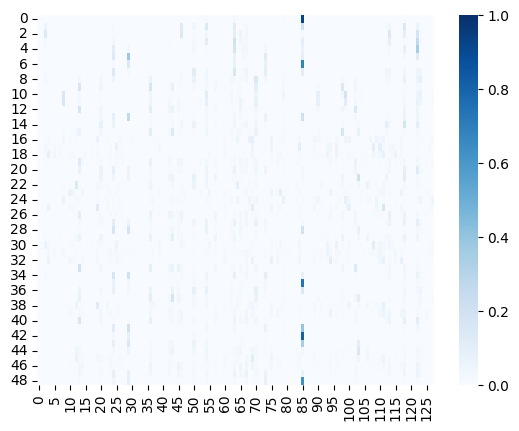

In [10]:
book_idxs = np.array([r["book_idx"] for r in results])
labels = np.array([r["label"] for r in results])

latent_idx_counts = {
    i: np.array([[0 for k in range(config.book_size)] for j in range(7 * 7)])  # zq (b, 7, 7)
    for i in range(config.n_clusters)
}
for label, book_idx in zip(labels, book_idxs):
    for j, k in enumerate(book_idx):
        latent_idx_counts[label][j, k] += 1

for label, counts in latent_idx_counts.items():
    print(label)
    cm = np.array(counts)
    cm = cm / cm.sum(axis=1).reshape(-1, 1)
    sns.heatmap(cm, cmap="Blues", vmax=1.0, vmin=0.0)
    plt.show()

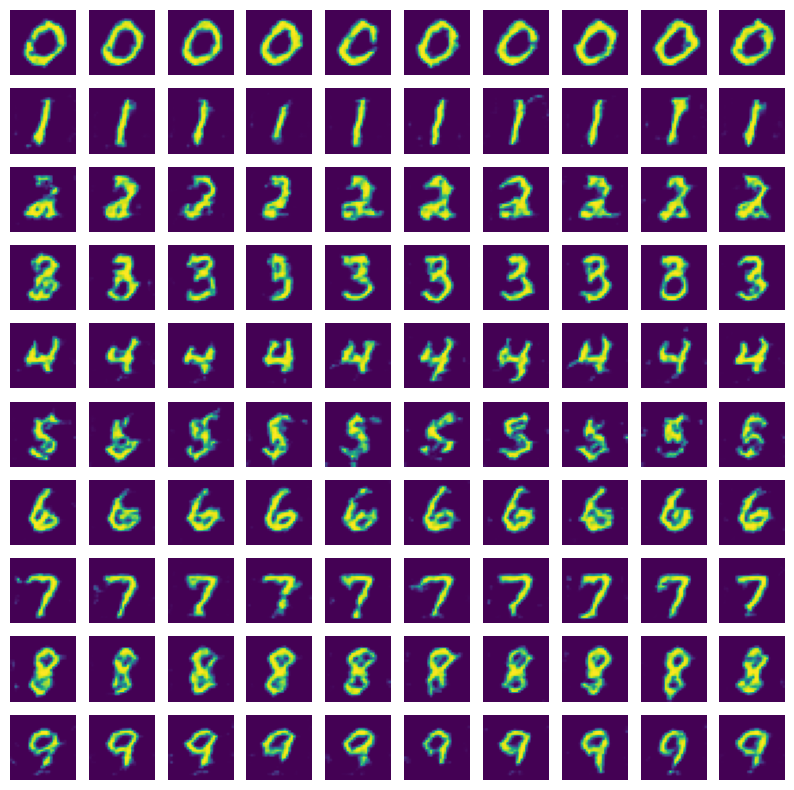

In [11]:
nsamples = 10
# generate images
result_gen = []
for i in range(config.n_clusters):
    c_probs = torch.eye(config.n_clusters)[i]
    c_probs = c_probs.unsqueeze(0).repeat(nsamples, 1)
    result_gen += model.sample(c_probs)

imgs_gen = [r["gen_x"] for r in result_gen]
plot_imgs(imgs_gen, nsamples * config.n_clusters)